In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import statsmodels.api as sm
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('../data/processed_data/data_1.csv')

In [3]:
df.head()

,CRASH_DATETIME,CASUALTY,FRONT_OR_BACK_ENDED,GOING_STRAIGHT_AHEAD,IN_INTERSECTION,TRUCK_TAXI_BIKE,CLUSTER
0,07/01/2012 10:40,0,0,0,0,0,45
1,07/01/2012 12:18,0,0,0,0,1,25
2,07/01/2012 18:00,0,0,0,0,0,69
3,07/01/2012 19:30,0,0,0,0,0,69
4,07/01/2012 20:00,0,0,0,0,1,58


# EDA

In [4]:
df['CRASH_DATETIME'] = pd.to_datetime(df['CRASH_DATETIME'])

In [5]:
df = df.set_index('CRASH_DATETIME').resample('W')[['CASUALTY']].sum()

In [6]:
df.shape

(493, 1)

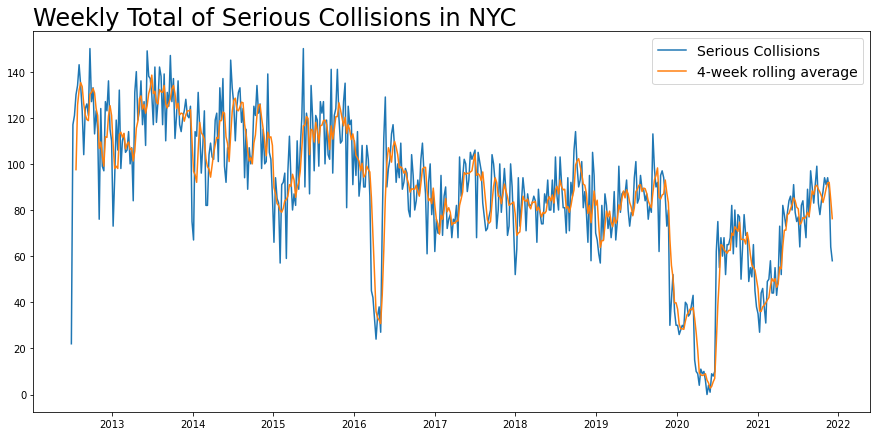

In [7]:
fig, ax = plt.subplots(1, figsize=(15,7))
ax.plot(df['CASUALTY'], label='Serious Collisions')
ax.plot(df.rolling(4).mean(), label='4-week rolling average')
ax.set_title('Weekly Total of Serious Collisions in NYC', loc='left', fontsize=24)
ax.legend(fontsize=14)

fig.savefig('../images/weekly_collisions.png', transparent=True, bbox_inches="tight");

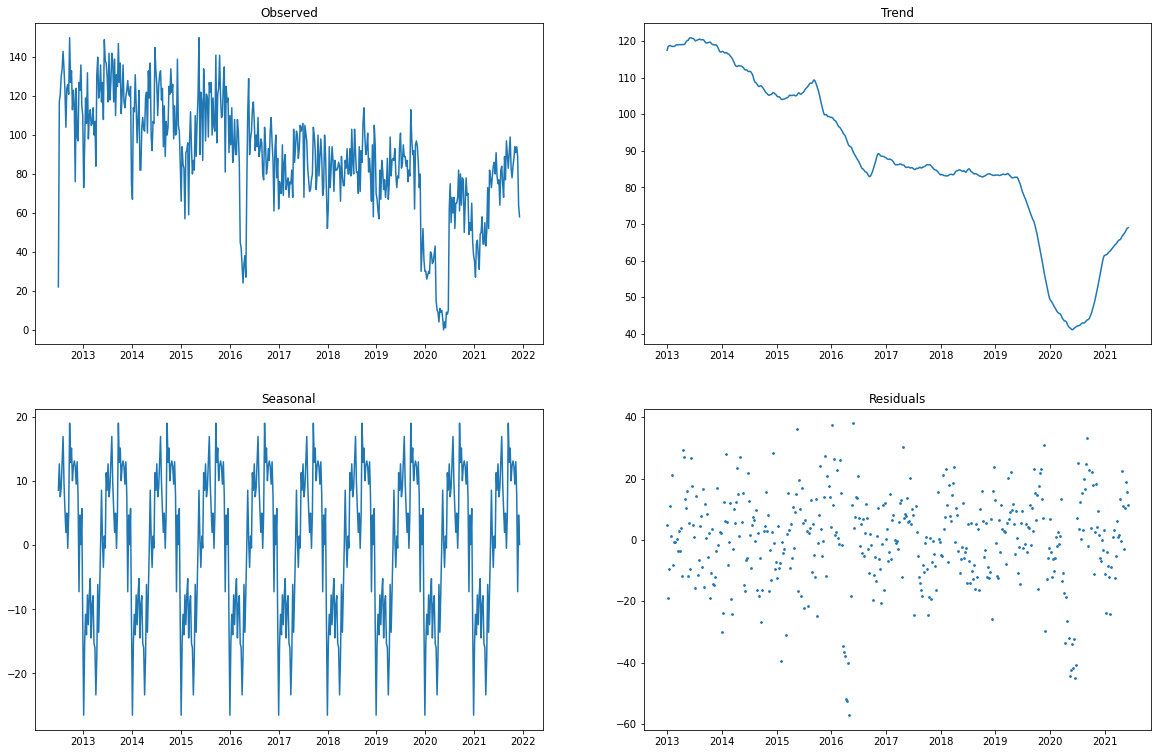

In [8]:
# Decompose time series into trend, seasonal, and residual components.
decomp = seasonal_decompose(df['CASUALTY'])

fig, ax = plt.subplots(2, 2, figsize=(20, 13))
ax[0][0].plot(decomp.observed)
ax[0][1].plot(decomp.trend)
ax[1][0].plot(decomp.seasonal)
ax[1][1].scatter(decomp.resid.index, decomp.resid.values, s=3)

ax[0][0].set_title('Observed')
ax[0][1].set_title('Trend')
ax[1][0].set_title('Seasonal')
ax[1][1].set_title('Residuals')

fig.savefig('../images/seasonal_decompose.png', transparent=True, bbox_inches="tight");

### ACF plot

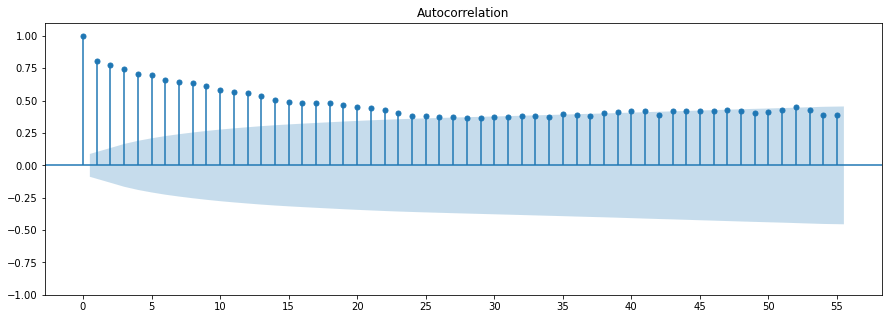

In [10]:
fig, ax = plt.subplots(1, figsize=(15, 5))
plot_acf(df['CASUALTY'], lags=55, ax=ax)
ax.set_xticks(range(0, 56, 5))
ax.set_ylim(-1, 1.1);

#fig.savefig('../images/pacf.png', transparent=True, bbox_inches="tight");

### PACF plot

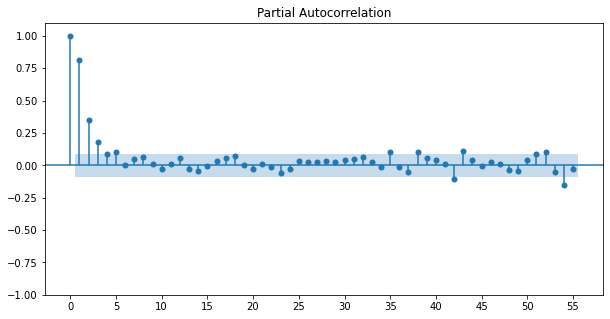

In [11]:
fig, ax = plt.subplots(1, figsize=(10, 5))
plot_pacf(df['CASUALTY'], lags=55, ax=ax, method='yw')
ax.set_xticks(range(0, 56, 5))
ax.set_ylim(-1, 1.1)

fig.savefig('../images/pacf.png', transparent=True, bbox_inches="tight");

# Preprocessing

In [12]:
#for i in [*range(1, 9), 13, 14]:
for i in [*range(1, 3), 54]:
    df[f"lag_{i}"] = df['CASUALTY'].shift(i)
    
df['time'] = range(df.shape[0])
df['covid'] = df.index.to_series().between('2020-03-01', '2020-07-01').astype(int)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['CASUALTY']), df['CASUALTY'], test_size=0.15, shuffle=False)

# Model: OLS

In [14]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [15]:
X_train = X_train.dropna()
y_train = y_train[X_train.index]

In [16]:
lm = sm.OLS(y_train, X_train)
lm_results = lm.fit()

In [17]:
print(lm_results.summary())

                            OLS Regression Results                            
Dep. Variable:               CASUALTY   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     181.5
Date:                Wed, 14 Dec 2022   Prob (F-statistic):           5.89e-96
Time:                        22:20:09   Log-Likelihood:                -1520.1
No. Observations:                 365   AIC:                             3052.
Df Residuals:                     359   BIC:                             3076.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.7175      7.787      5.999      0.0

In [18]:
preds = lm_results.predict(X_test)

In [19]:
# Calculate R2 score.
print("Train R2 =", r2_score(y_train, lm_results.predict(X_train)))
print("Test R2  =", r2_score(y_test, lm_results.predict(X_test)))

Train R2 = 0.7165350977918374
Test R2  = 0.5446715434282317


In [20]:
y_test.index[[0, -1]]

DatetimeIndex(['2020-07-12', '2021-12-05'], dtype='datetime64[ns]', name='CRASH_DATETIME', freq=None)

# Plot results

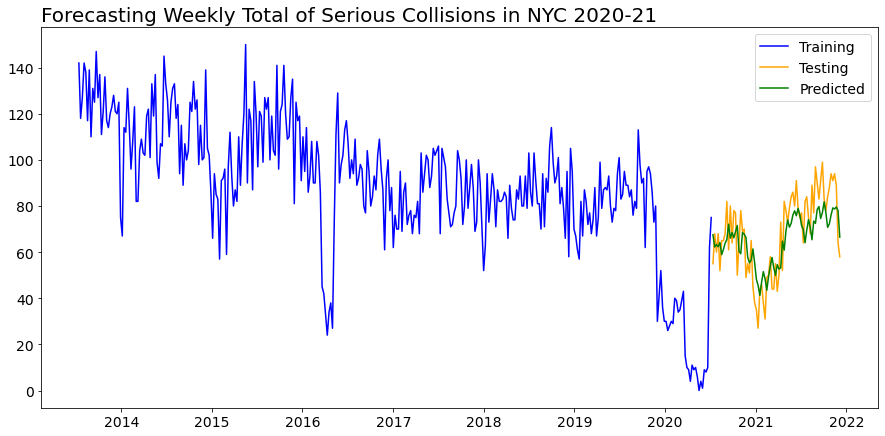

In [22]:
fig, ax = plt.subplots(1, figsize=(15, 7))
ax.plot(y_train, color='blue', label='Training')
ax.plot(y_test, color='orange', label='Testing')
ax.plot(preds, color='green', label='Predicted')
ax.set_title(label = 'Forecasting Weekly Total of Serious Collisions in NYC 2020-21', fontsize=20, loc='left')
ax.tick_params(axis='both', which='major', labelsize=14);
ax.legend(fontsize=14)
fig.savefig('../images/weekly_collisions_forecast.png', transparent=True, bbox_inches="tight");